
Running Mode: WITHOUT_ATTENTION
Epoch 1, Loss: 821.5394, Validation Loss: 6.1938
Epoch 2, Loss: 735.6160, Validation Loss: 6.0596
Epoch 3, Loss: 700.3066, Validation Loss: 5.9880
Epoch 4, Loss: 662.2841, Validation Loss: 5.8819
Epoch 5, Loss: 623.6173, Validation Loss: 5.9330
Epoch 6, Loss: 579.5349, Validation Loss: 5.5378
Epoch 7, Loss: 538.4762, Validation Loss: 5.7476
Epoch 8, Loss: 504.5350, Validation Loss: 5.5821
Epoch 9, Loss: 465.0581, Validation Loss: 5.7569
Epoch 10, Loss: 431.1803, Validation Loss: 5.8820
Epoch 11, Loss: 399.8656, Validation Loss: 5.8770
Epoch 12, Loss: 359.6317, Validation Loss: 5.8866
Epoch 13, Loss: 324.6131, Validation Loss: 5.7944
Epoch 14, Loss: 292.3467, Validation Loss: 5.6518
Epoch 15, Loss: 259.1364, Validation Loss: 5.7298
Epoch 16, Loss: 224.0502, Validation Loss: 5.8652
Epoch 17, Loss: 196.6747, Validation Loss: 5.8605
Epoch 18, Loss: 173.5753, Validation Loss: 5.8048
Epoch 19, Loss: 148.1920, Validation Loss: 5.6613
Epoch 20, Loss: 127.8097, 

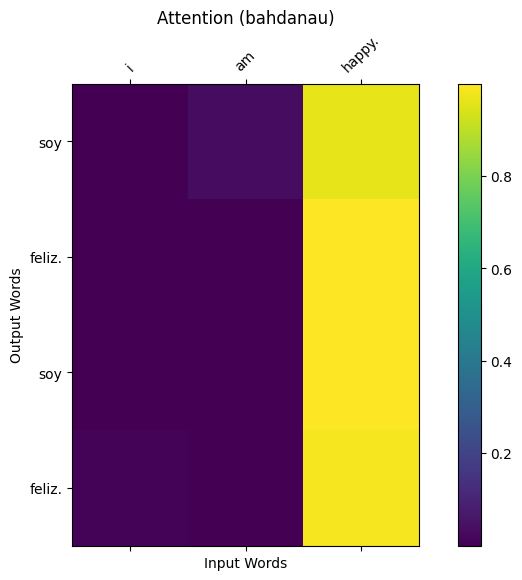


Running Mode: LUONG
Epoch 1, Loss: 808.6534, Validation Loss: 6.0426
Epoch 2, Loss: 676.3675, Validation Loss: 5.4917
Epoch 3, Loss: 575.6257, Validation Loss: 5.2566
Epoch 4, Loss: 477.1840, Validation Loss: 5.1667
Epoch 5, Loss: 383.3972, Validation Loss: 5.2450
Epoch 6, Loss: 301.4418, Validation Loss: 5.2999
Epoch 7, Loss: 240.6132, Validation Loss: 5.1125
Epoch 8, Loss: 205.9719, Validation Loss: 4.8224
Epoch 9, Loss: 175.1543, Validation Loss: 5.1078
Epoch 10, Loss: 149.5877, Validation Loss: 5.1793
Epoch 11, Loss: 129.5595, Validation Loss: 5.1050
Epoch 12, Loss: 107.5296, Validation Loss: 5.0921
Epoch 13, Loss: 92.5171, Validation Loss: 5.1267
Epoch 14, Loss: 79.6839, Validation Loss: 5.3496
Epoch 15, Loss: 63.6964, Validation Loss: 5.8098
Epoch 16, Loss: 53.9893, Validation Loss: 5.5734
Epoch 17, Loss: 47.4841, Validation Loss: 5.3015
Epoch 18, Loss: 39.6783, Validation Loss: 5.2575
Epoch 19, Loss: 33.7091, Validation Loss: 6.0416
Epoch 20, Loss: 30.5761, Validation Loss: 5.5

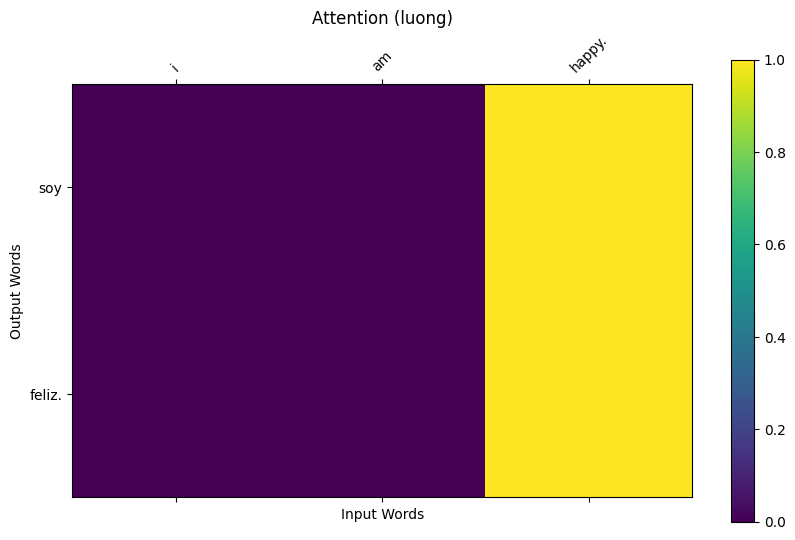

In [1]:
# Sequence-to-Sequence Learning with LSTM

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Check If CUDA is Available, Else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modes = ["without_attention", "bahdanau", "luong"]

# Load Dataset
def load_data(path, limit = 10000):
    with open(path, "r", encoding = 'utf-8') as f:
        lines = [line.strip().split('\t') for line in f if '\t' in line]
    random.shuffle(lines)

    return lines[:limit]

# Build Vocabulary
def build_vocab(sentences):
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    counter = Counter(word for s in sentences for word in s.lower().split())
    for word in counter:
        vocab[word] = len(vocab)

    return vocab

# Tokenize Sentence
def tokenize(sentence, vocab):
    return [vocab.get(w, vocab['<unk>']) for w in sentence.lower().split()]

# Prepare Dataset
def prepare_dataset(pairs, src_vocab, tgt_vocab):
    X, Y = [], []
    for src, tgt in pairs:
        x = tokenize(src, src_vocab)
        y = [tgt_vocab['<sos>']] + tokenize(tgt, tgt_vocab) + [tgt_vocab['<eos>']]
        X.append(torch.tensor(x, dtype = torch.long))
        Y.append(torch.tensor(y, dtype = torch.long))

    return X, Y

# Pad Batch
def collate_fn(batch_x, batch_y):
    src = pad_sequence(batch_x, batch_first = True, padding_value = src_vocab['<pad>'])
    tgt = pad_sequence(batch_y, batch_first = True, padding_value = tgt_vocab['<pad>'])
    return src.to(device), tgt.to(device)

# Encoder
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first = True)

    def forward(self, x):
        x = self.embedding(x)
        outputs, (h, c) = self.lstm(x)

        return outputs, (h, c)

# Bahdanau Attention
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        score = torch.sum(self.v * energy, dim = 2)

        return torch.softmax(score, dim = 1)

# Luong Attention
class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, hidden_size)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(2)
        energy = self.attn(encoder_outputs)
        score = torch.bmm(energy, hidden).squeeze(2)

        return torch.softmax(score, dim = 1)

# Decoder
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, mode):
        super().__init__()
        self.mode = mode
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attn = BahdanauAttention(hidden_size) if mode == "bahdanau" else \
                    LuongAttention(hidden_size) if mode == "luong" else None
        self.lstm = nn.LSTM(embed_size + hidden_size if self.attn else embed_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size * 2 if self.attn else hidden_size, vocab_size)

    def forward(self, x, hidden, cell, encoder_outputs = None):
        x = self.embedding(x.unsqueeze(1))
        attn_weights = None
        if self.attn:
            attn_weights = self.attn(hidden, encoder_outputs)
            context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
            x = torch.cat((x, context), dim = 2)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        if self.attn:
            output = torch.cat((output.squeeze(1), context.squeeze(1)), dim = 1)
        else:
            output = output.squeeze(1)

        return self.fc(output), hidden, cell, attn_weights

# Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt, teacher_forcing = 0.5):
        batch_size, tgt_len = tgt.shape
        vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(device)
        enc_outputs, (h, c) = self.encoder(src)
        x = tgt[:, 0]
        for t in range(1, tgt_len):
            out, h, c, _ = self.decoder(x, h, c, enc_outputs if self.decoder.attn else None)
            outputs[:, t] = out
            x = tgt[:, t] if random.random() < teacher_forcing else out.argmax(1)

        return outputs

# Training the Model
# Training the Model
def train(model, xdata, ydata, val_data = None, epochs = 5):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])
    for epoch in range(epochs):
        total_loss = 0
        for i in range(0, len(xdata), 64):
            src, tgt = collate_fn(xdata[i:i+64], ydata[i:i+64])
            output = model(src, tgt)
            loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if val_data:
            model.eval()
            val_x, val_y = val_data
            with torch.no_grad():
                src, tgt = collate_fn(val_x, val_y)
                output = model(src, tgt)
                val_loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
            print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Validation Loss: {val_loss.item():.4f}")
            model.train()
        else:
            print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Translate
def translate(model, sentence):
    model.eval()
    tokens = tokenize(sentence, src_vocab)
    src = torch.tensor(tokens).unsqueeze(0).to(device)
    enc_outputs, (h, c) = model.encoder(src)
    x = torch.tensor([tgt_vocab['<sos>']]).to(device)
    result = []
    for _ in range(20):
        out, h, c, _ = model.decoder(x, h, c, enc_outputs if model.decoder.attn else None)
        x = out.argmax(1)
        word = tgt_ivocab[x.item()]
        if word == "<eos>":
            break
        result.append(word)

    return ' '.join(result)

# BLEU Evaluation
def evaluate_bleu(model):
    refs, preds = [], []
    for x, y in zip(X_test[:100], Y_test[:100]):
        src_sent = ' '.join([src_ivocab[t.item()] for t in x])
        tgt_sent = [tgt_ivocab[t.item()] for t in y[1:-1]]
        pred = translate(model, src_sent).split()
        refs.append([tgt_sent])
        preds.append(pred)

    smoothing = SmoothingFunction().method1
    return corpus_bleu(refs, preds, smoothing_function = smoothing)

# Attention Visualization
def visualize_attention(model, sentence):
    if MODE == "without_attention":
        print("No Attention to Visualize.")
        return
    model.eval()
    tokens = tokenize(sentence, src_vocab)
    src = torch.tensor(tokens).unsqueeze(0).to(device)
    enc_outputs, (h, c) = model.encoder(src)
    x = torch.tensor([tgt_vocab['<sos>']]).to(device)
    result = []
    attentions = []
    for _ in range(20):
        out, h, c, attn = model.decoder(x, h, c, enc_outputs)
        x = out.argmax(1)
        word = tgt_ivocab[x.item()]
        if word == "<eos>":
            break
        result.append(word)
        attentions.append(attn.squeeze(0).cpu().detach().numpy())

    src_words = [src_ivocab[i] for i in tokens]
    fig = plt.figure(figsize = (10, 6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.stack(attentions), cmap = "viridis")
    ax.set_xticks(range(len(src_words)))
    ax.set_yticks(range(len(result)))
    ax.set_xticklabels(src_words, rotation = 45)
    ax.set_yticklabels(result)
    ax.set_xlabel("Input Words")
    ax.set_ylabel("Output Words")
    plt.colorbar(cax)
    plt.title(f"Attention ({MODE})")
    plt.show()

# Load and Prepare Data
pairs = load_data("/kaggle/input/english-to-spanish/spa.txt")

src_text = [pair[0] for pair in pairs]
tgt_text = [pair[1] for pair in pairs]
src_vocab = build_vocab(src_text)
tgt_vocab = build_vocab(tgt_text)
src_ivocab = {i: w for w, i in src_vocab.items()}
tgt_ivocab = {i: w for w, i in tgt_vocab.items()}

X, Y = prepare_dataset(pairs, src_vocab, tgt_vocab)

# 10% Split for Test
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size = 0.1)

# 10% Split for Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size = 0.1111)

# Run all Modes
for MODE in modes:
    print(f"\nRunning Mode: {MODE.upper()}")

    encoder = Encoder(len(src_vocab), 256, 512).to(device)
    decoder = Decoder(len(tgt_vocab), 256, 512, MODE).to(device)
    model = Seq2Seq(encoder, decoder).to(device)

    train(model, X_train, Y_train, val_data = (X_val, Y_val), epochs = 200)

    print("Translate:", translate(model, "I am happy."))
    print("BLEU Score:", evaluate_bleu(model))

    if MODE != "without_attention":
        visualize_attention(model, "I am happy.")
    else:
        print("No Attention Visualization (without_attention Mode).")